<a href="https://colab.research.google.com/github/nucontreras/artificial-intelligence-scripts/blob/main/FSCN/Barras/bar_chart_old.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<b><FONT size="8" color='264653'>Audiographics Project: sonification for the accessibility of quantitative information in graphic format </FONT>

><b><FONT size="3" color='DimGray'> Sonification for the accessibility of quantitative information in graphic format is part of the research line in Technology and Care of the Millennium Institute for Care Research ([MICARE](https://www.micare.cl/)). The objective of this project is to implement a tool for the transformation of quantitative information presented in visual form into audio to facilitate access to visually handicapped people, using sonification techniques and image analysis through artificial intelligence. </FONT>

><b><FONT size="3" color='DimGray'> This file contains the processing, treatment and tests of a neural network used to filter bar chart images. </FONT>

><b><FONT size="3" color='SlateGray'> Code edited from an old code made in an iPre. </FONT>

# <b><FONT size="5" color='MidnightBlue '>Connection to Google Drive </FONT>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

%cd 'gdrive/MyDrive/AudioGraphs'

Mounted at /content/gdrive
/content/gdrive/MyDrive/AudioGraphs


#<b><FONT size="5" color='MidnightBlue '>Import of packages </FONT>



In [3]:
import os
import sys
import numpy as np
from datetime import datetime
from random import shuffle, seed

# Data processing and visualization
import matplotlib.pyplot as plt
import cv2

# AI models
import tensorflow as tf
from keras.utils import Sequence, plot_model
from keras.preprocessing import image
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose
from keras.models import Model, load_model
from keras.callbacks import EarlyStopping

seed(420)

#<b><FONT color='MidnightBlue' size='6'>Functions</FONT></b>

#<b><FONT color='MidnightBlue' size='6'>Classes</FONT></b>

<b><FONT size="5" color='MidnightBlue '>Generator </FONT>


><b><FONT size="3" color='DimGray'> Creation of the generator to pass the images to the model for training it. </FONT>


In [12]:
class DataGenerator(Sequence):
    def __init__(self, directory, targets_dir, color_mode="grayscale", subdirs=False, batch_size=32, dim=(256, 256), n_channels=1, shuffle=True):
        self.x = self.read_directory(directory, subdirs)
        self.directory = directory
        self.targets_dir = targets_dir
        self.len = len(self.x)
        self.batch_size = batch_size
        self.dim = dim
        self.n_channels = n_channels
        self.shuffle = shuffle
#         self.on_epoch_end()

    def read_directory(self, directory, subdirs):
        if not subdirs:
            # Temporary ._ problem fix
            elements = []
            elements_tmp = os.listdir(directory)
            for elem in elements_tmp:
                if '._' not in elem:
                    elements.append(elem)
            return elements
        raise FileExistsError

    def __len__(self):
        return int(self.len // self.batch_size)

    def __getitem__(self, index):
        batch = self.x[index * self.batch_size : (index + 1) * self.batch_size]
        x, y = self.read_images(batch)

        return x, y

    def on_epoch_end(self):
        if self.shuffle == True:
            shuffle(self.x)

    def read_images(self, batch):
        # Inicialización de datos
        # X e y son de igual dimensión ya que ambos son imágenes
        # X : (n_samples, *dim, n_channels)
        x, y = [], []

        # Generación de data
        for i, name in enumerate(batch):
            path = self.directory + "/" + name
            img = tf.keras.utils.load_img(path, target_size=(256, 256), color_mode="grayscale")
            img = tf.keras.utils.img_to_array(img)
            x.append(img / 255)

            target_path = self.targets_dir + "/" + name
            target_img = tf.keras.utils.load_img(target_path, target_size=(256, 256), color_mode="grayscale")
            target_img = tf.keras.utils.img_to_array(target_img)
            y.append(target_img / 255)

        return np.array(x), np.array(y)

<b><FONT size="4" color='619b8a'>Path to bar chart images dataset  </FONT>

In [4]:
path_bar_chart_db = 'Codigos y BD anteriores/Barras/models/'

#<b><FONT color='MidnightBlue' size='6'>Neural network </FONT></b>

<b><FONT size="5" color='MidnightBlue '>FSCN Model </FONT>

In [4]:
#with tf.device('/device:GPU:0'):
input_layer = Input(shape=(256, 256, 1), name="INPUT")
x = Conv2D(64, (3, 3), activation='relu', padding='same')(input_layer)
x = Conv2DTranspose(64, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = Conv2DTranspose(64, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = Conv2DTranspose(64, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = Conv2DTranspose(64, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = Conv2DTranspose(64, (3, 3), activation='relu', padding='same')(x)
output_layer = Conv2D(1, (3, 3), padding='same', name="OUTPUT")(x)

model = Model(input_layer, output_layer)
model.compile(optimizer='adam', loss="mse")
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 INPUT (InputLayer)          [(None, 256, 256, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 64)      640       
                                                                 
 conv2d_transpose (Conv2DTra  (None, 256, 256, 64)     36928     
 nspose)                                                         
                                                                 
 conv2d_1 (Conv2D)           (None, 256, 256, 64)      36928     
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 256, 256, 64)     36928     
 ranspose)                                                       
                                                                 
 conv2d_2 (Conv2D)           (None, 256, 256, 64)      36928 

In [13]:
train_path_x = path_bar_chart_db + "dataset/segmentation-2/train/grises"
train_path_y = path_bar_chart_db + "dataset/segmentation-2/train/segmented"

test_path_x = path_bar_chart_db + "dataset/segmentation-2/test/grises"
test_path_y = path_bar_chart_db + "dataset/segmentation-2/test/segmented"

train_gen = DataGenerator(train_path_x, train_path_y)
test_gen = DataGenerator(test_path_x, test_path_y)

In [14]:
train_gen.__getitem__(3)[1][0].shape
# len(train_gen)

(256, 256, 1)

In [15]:
train_gen.len

5000

#<b><FONT color='MidnightBlue' size='6'>Training </FONT></b>

In [16]:
from keras.callbacks import EarlyStopping

# Early Stopping
es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=5, restore_best_weights=True)

#with tf.device('/device:GPU:0'):
history = model.fit(train_gen,
                    verbose=1,
                    steps_per_epoch=5,
                    epochs=30)

loss = history.history['loss']

Epoch 1/30
5/5 [==============================] - 53s 6s/step - loss: 0.5831
Epoch 2/30
5/5 [==============================] - 38s 7s/step - loss: 0.4582
Epoch 3/30
5/5 [==============================] - 35s 7s/step - loss: 0.2404
Epoch 4/30
5/5 [==============================] - 35s 7s/step - loss: 0.1471
Epoch 5/30
5/5 [==============================] - 33s 6s/step - loss: 0.0989
Epoch 6/30
5/5 [==============================] - 33s 6s/step - loss: 0.0893
Epoch 7/30
5/5 [==============================] - 28s 5s/step - loss: 0.0694
Epoch 8/30
5/5 [==============================] - 32s 6s/step - loss: 0.0616
Epoch 9/30
5/5 [==============================] - 29s 5s/step - loss: 0.0511
Epoch 10/30
5/5 [==============================] - 29s 6s/step - loss: 0.0523
Epoch 11/30
5/5 [==============================] - 28s 5s/step - loss: 0.0411
Epoch 12/30
5/5 [==============================] - 25s 5s/step - loss: 0.0361
Epoch 13/30
5/5 [==============================] - 22s 4s/step - loss: 0.


#<b><FONT color='MidnightBlue' size='6'>Evaluation </FONT></b>

In [17]:
def evaluate(model, img_path):
    "Recibe un modelo y un path a una imagen y retorna la imagen y el output como np arrays"
    img = tf.keras.utils.load_img(img_path, target_size=(256, 256), color_mode = "grayscale")
    img = tf.keras.utils.img_to_array(img) / 255
#     print(img.shape)
    segmented = model.predict(img)
    return img, segmented[:,:,:,0]

def normalize_img(img):
    return (img - img.min()) / (img.max() - img.min())

8/8 [==============================] - 1s 8ms/step


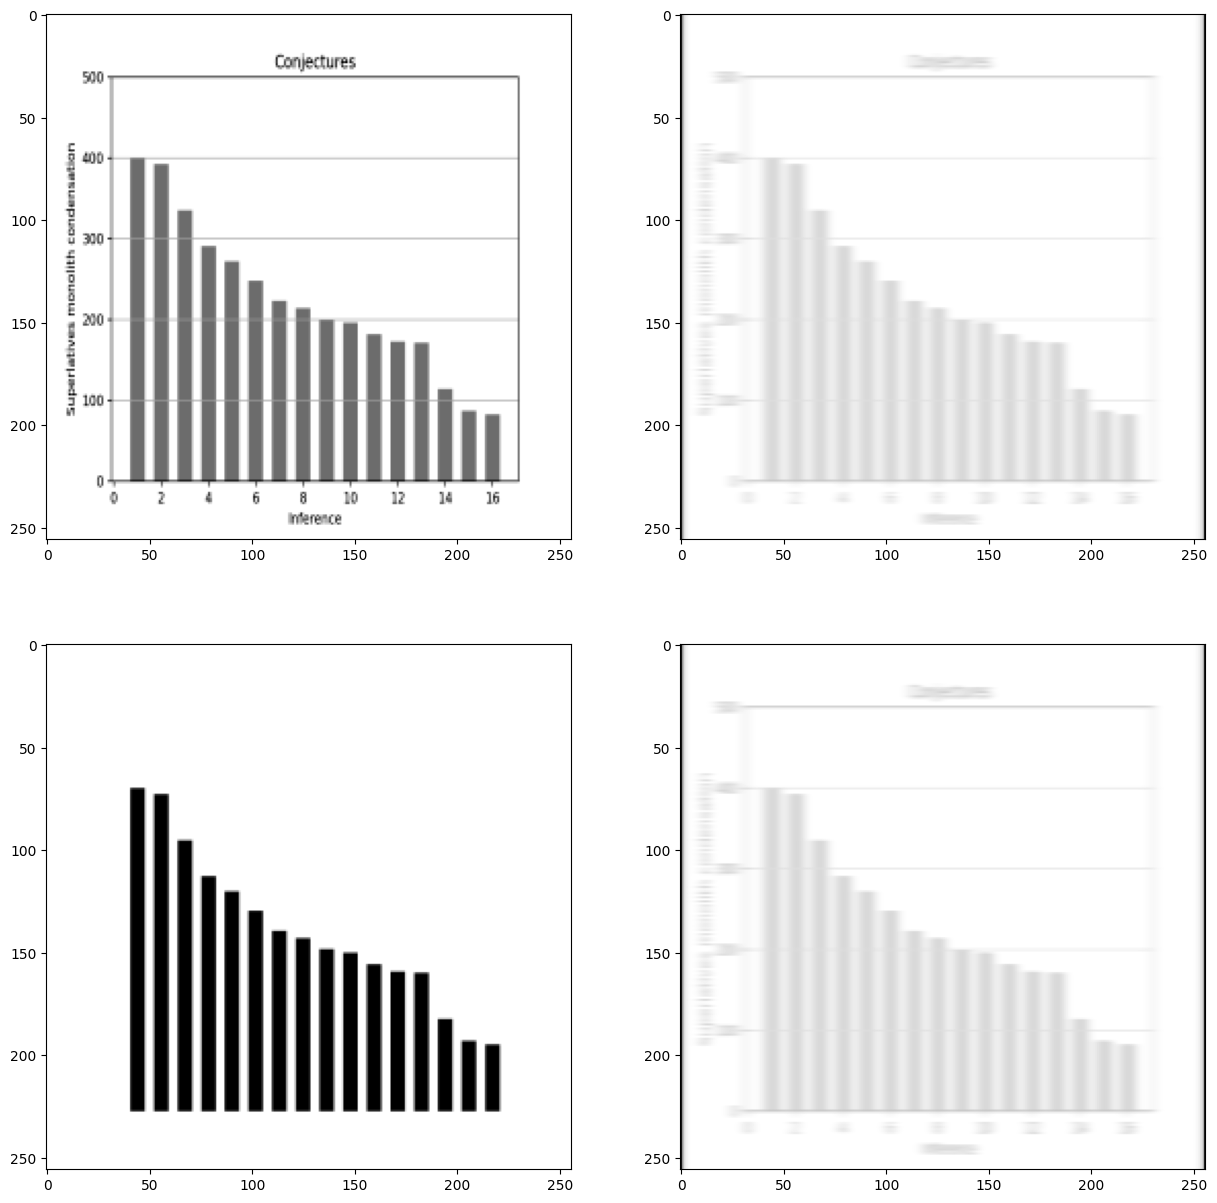

In [19]:
n = 3
img_path = path_bar_chart_db + f"dataset/segmentation-2/train/grises/{n}.png"
target_path = path_bar_chart_db + f"dataset/segmentation-2/train/segmented/{n}.png"

img, segmented = evaluate(model, img_path)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
fig.set_size_inches(15, 15)

ax1.imshow(img, cmap="gray")
ax2.imshow(segmented, cmap="gray")

target = tf.keras.utils.load_img(target_path, target_size=(256, 256), color_mode = "grayscale")
target = tf.keras.utils.img_to_array(target)
ax3.imshow(target, cmap="gray")

# print(segmented)
ax4.imshow(normalize_img(segmented), cmap="gray")

# print(normalize_img(segmented))
# print(segmented)

# print(segmented[150], img[150])

# print(segmented[:, :, :, 0])

#<b><FONT color='MidnightBlue' size='6'>Save Model </FONT></b>

In [10]:
def save_model(model, name):
    "Guarda un modelo como h5"
    path = "Trained Models/"

    td = datetime.now()
    final_name = name + f"-{td.day}-{td.month}-{td.year}"
    model.save(path + final_name + ".h5", save_format="h5")

def load_model(model_path):
    return tf.keras.models.load_model(model_path)

In [33]:
save_model(model, "model-old-db-bar")

In [11]:
def show_data(model, img_path):
    # IMG EN NP ARRAY (1, 256, 256, 1)
    full_img = []
    img = tf.keras.utils.load_img(img_path, target_size=(256, 256), color_mode = "grayscale")
    img = tf.keras.utils.img_to_array(img)
    img = ((img - img.min())/(img.max() - img.min())) #MIN MAX
    full_img.append(img)
    full_img = np.array(full_img)

    # PREDICCION
    pred = model.predict(full_img)

    # NORMALIZACIÓN
    pred = ((pred - pred.min())/(pred.max() - pred.min()))

    # THRESHOLD
    thresh = cv2.threshold(pred[0,:,:,0], 0.8, 1, cv2.THRESH_BINARY)
    thresh = thresh[1].reshape(256,256)

    # ERODE-DILATE
    kernel = np.ones((3,3),np.uint8)
    erosion = cv2.erode(thresh,kernel,iterations = 1)
    dilate = cv2.dilate(erosion, kernel, iterations = 1)

    # DISPLAY
    plt.figure(figsize=(15, 15))
    plt.gray()
    ax = plt.subplot(2,2,1)
    plt.imshow(full_img.reshape(256,256))
    ax = plt.subplot(2,2,2)
    plt.imshow(pred.reshape(256,256))
    ax = plt.subplot(2,2,3)
    plt.imshow(thresh.reshape(256,256))
    ax = plt.subplot(2,2,4)
    plt.imshow(dilate.reshape(256,256))

<b>

#<b><FONT color='MidnightBlue' size='6'>Load Model </FONT></b>

In [5]:
model_path = "Trained Models/model-old-db-bar-16-7-2023.h5"

model_loaded = load_model(model_path)
model_loaded.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 INPUT (InputLayer)          [(None, 256, 256, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 64)      640       
                                                                 
 conv2d_transpose (Conv2DTra  (None, 256, 256, 64)     36928     
 nspose)                                                         
                                                                 
 conv2d_1 (Conv2D)           (None, 256, 256, 64)      36928     
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 256, 256, 64)     36928     
 ranspose)                                                       
                                                                 
 conv2d_2 (Conv2D)           (None, 256, 256, 64)      36928 

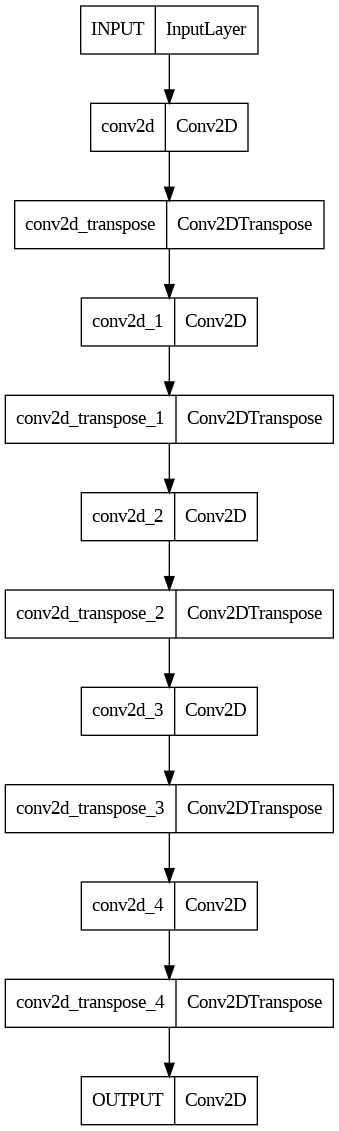

In [6]:
plot_model(model_loaded)

In [7]:
model_old_loaded_2021 = load_model('Trained Models/Old/2021-2021-18_15-28-38.h5')
model_old_loaded_FSCN1 = load_model('Trained Models/Old/FSCN1.h5')
model_old_loaded_FSCN2 = load_model('Trained Models/Old/FSCN2.h5')
model_old_loaded_FSCN3 = load_model('Trained Models/Old/FSCN3.h5')

1/1 [==============================] - 0s 284ms/step


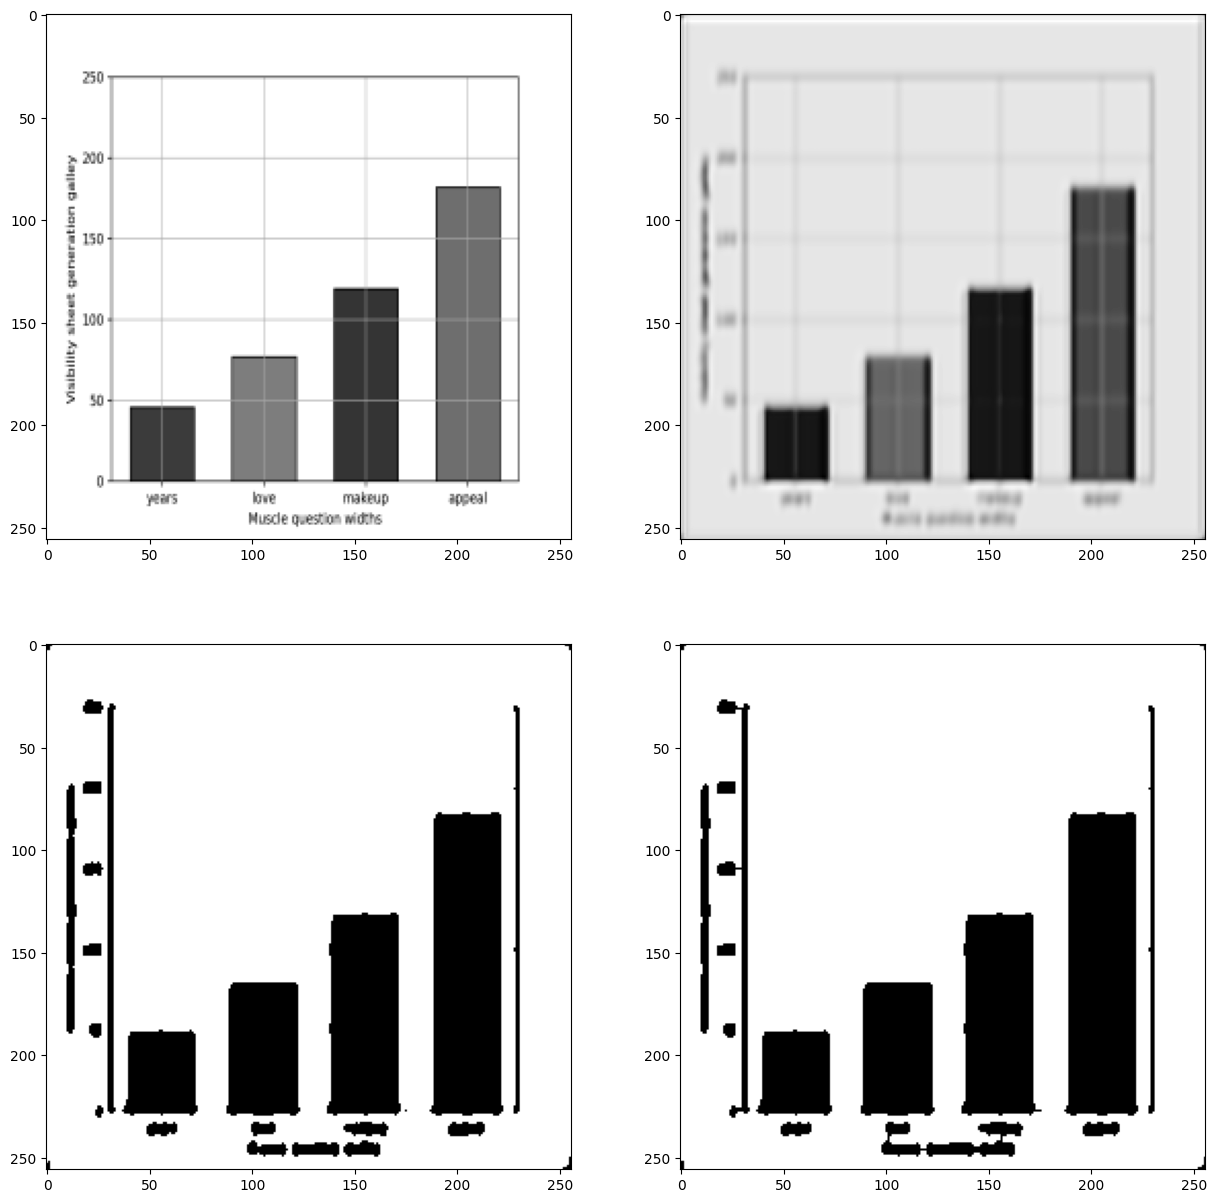

In [13]:
n = 100
img_path = path_bar_chart_db + f"dataset/segmentation-2/test/grises/{n}.png"
target_path = path_bar_chart_db + f"dataset/segmentation-2/train/segmented/{n}.png"

show_data(model_loaded, img_path)

1/1 [==============================] - 10s 10s/step


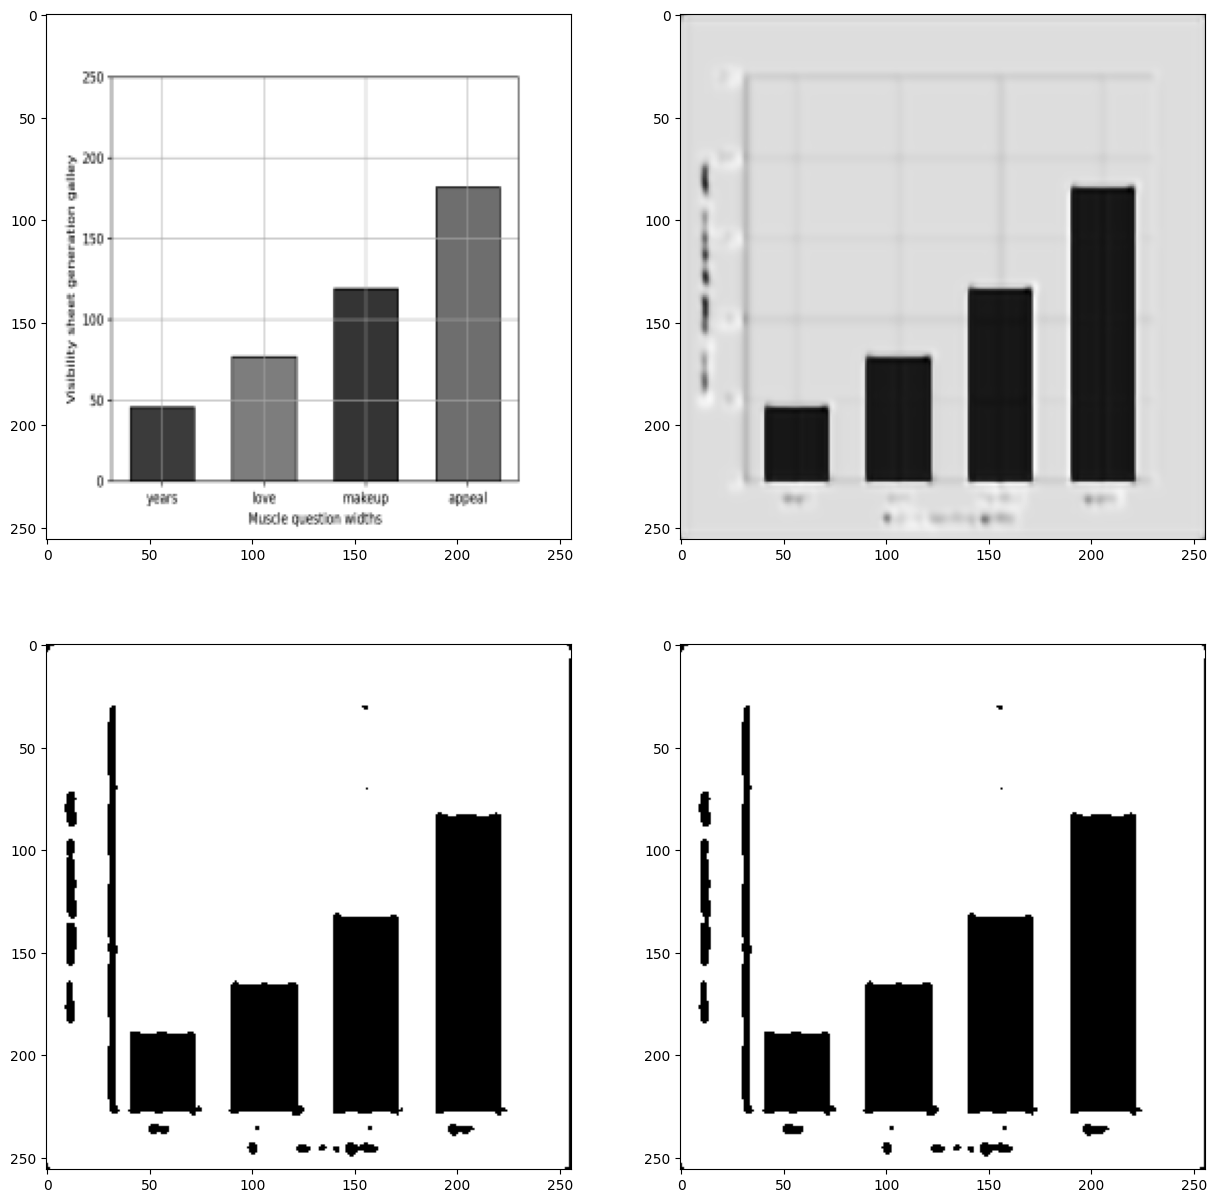

In [12]:
n = 100
img_path = path_bar_chart_db + f"dataset/segmentation-2/test/grises/{n}.png"
target_path = path_bar_chart_db + f"dataset/segmentation-2/train/segmented/{n}.png"

show_data(model_old_loaded_2021, img_path)

In [14]:
def minmax(img):
    img = (img - img.min())/(img.max() - img.min()) #MIN MAX
    return img

def test_model(model, img_path, img_shape, target_path=None):
    # IMG EN NP ARRAY (1, 256, 256, 1)
    # full_img = []
    img = tf.keras.utils.load_img(img_path, target_size=(256,256), color_mode="grayscale") #, interpolation="bicubic")
    img = tf.keras.utils.img_to_array(img)
    # img = minmax(img)

    # PREDICCION
    pred = model.predict(img[None,:,:,:]).reshape((256, 256))
    img = img.reshape((256, 256))

    # NORMALIZACIÓN
    # pred = ((pred - pred.min())/(pred.max() - pred.min()))
    # print(pred[0].shape)
    # print(minmax(pred))
    ret, thresh = cv2.threshold(minmax(pred), 0.5, 1, cv2.THRESH_BINARY)

    #DISPLAY
    plt.figure(figsize=(15, 15))
    plt.gray()
    ax = plt.subplot(2,2,1)
    plt.imshow(img)
    ax = plt.subplot(2,2,2)
    plt.imshow(pred)
    ax = plt.subplot(2,2,3)
    plt.imshow(thresh)

    # ax = plt.subplot(2,2,3)
    # plt.imshow(1-new)
    # ax = plt.subplot(2,2,4)
    # plt.imshow(onepixel_img(new))
    if target_path:
        target = tf.keras.utils.load_img(target_path, target_size=(256,256), color_mode="grayscale") #, interpolation="bicubic")
        target = tf.keras.utils.img_to_array(target)
        ax = plt.subplot(2,2,4)
        plt.imshow(target[:,:,0])

1/1 [==============================] - 0s 22ms/step


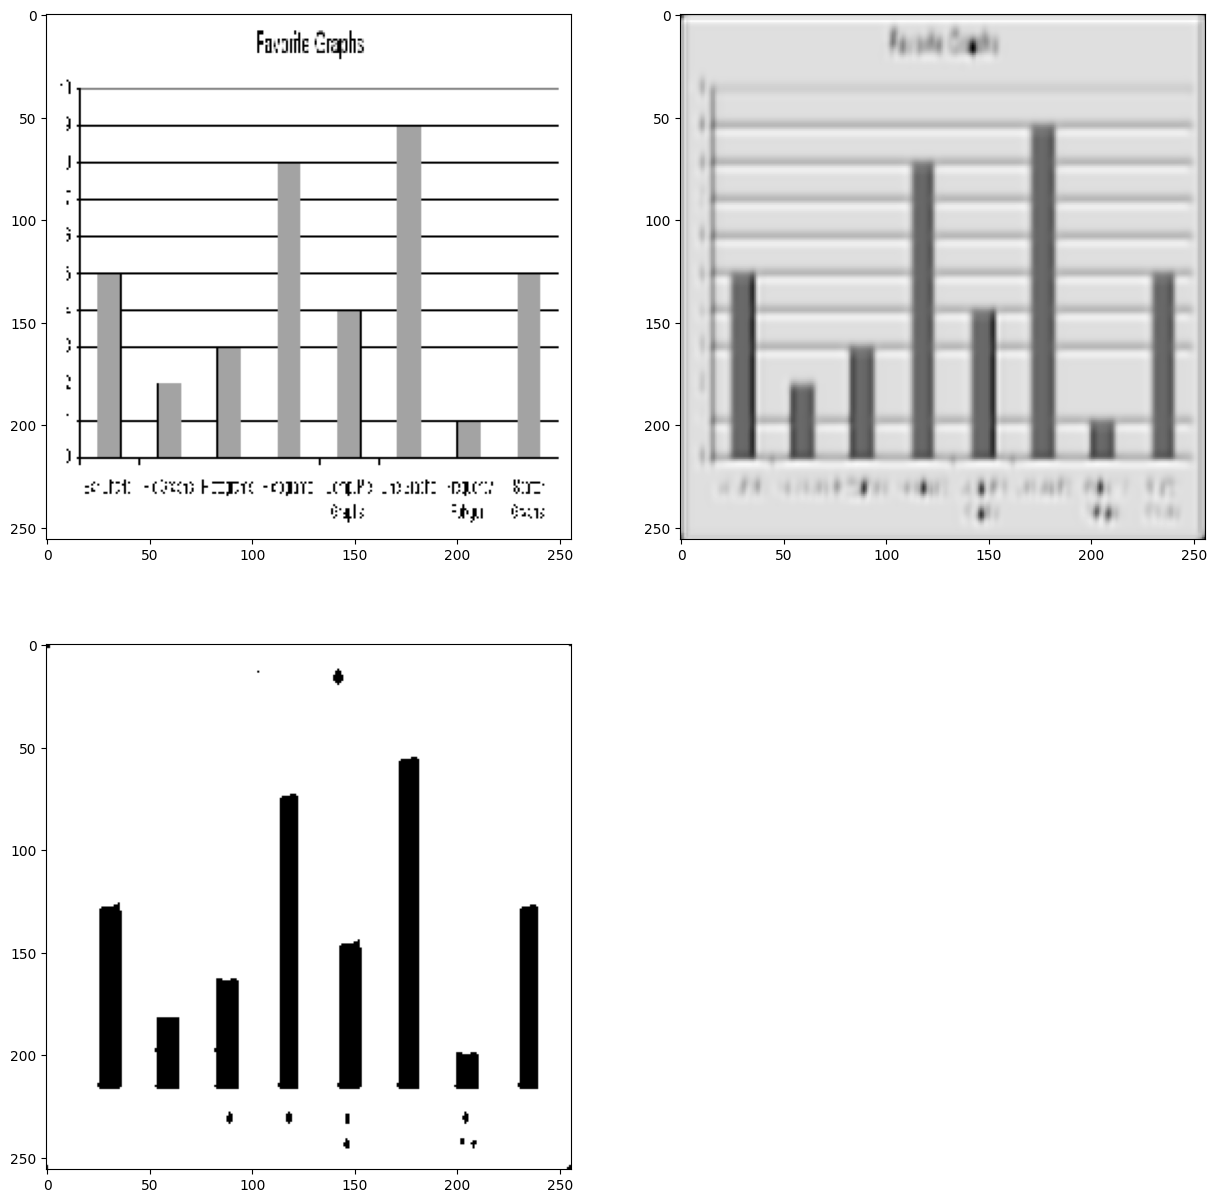

In [15]:
target_path = None
n = 1
# img_path = "Codigos y BD anteriores/Barras/" + f"dataset/segmentation-2/test/color/{n}.png"
img_path = "Codigos y BD anteriores/Barras/" + f"ejemplos/internet/buenos/1000.jpg"
# target_path = "Codigos y BD anteriores/Barras/" + f"dataset/segmentation-2/test/segmented/{n}.png"

# img_path = "Codigos y BD anteriores/Barras/" + "DB graficos internet/Barras Verticales/Copia de graph_1003.jpg"

test_model(model_loaded, img_path, (256, 256), target_path)

1/1 [==============================] - 0s 28ms/step


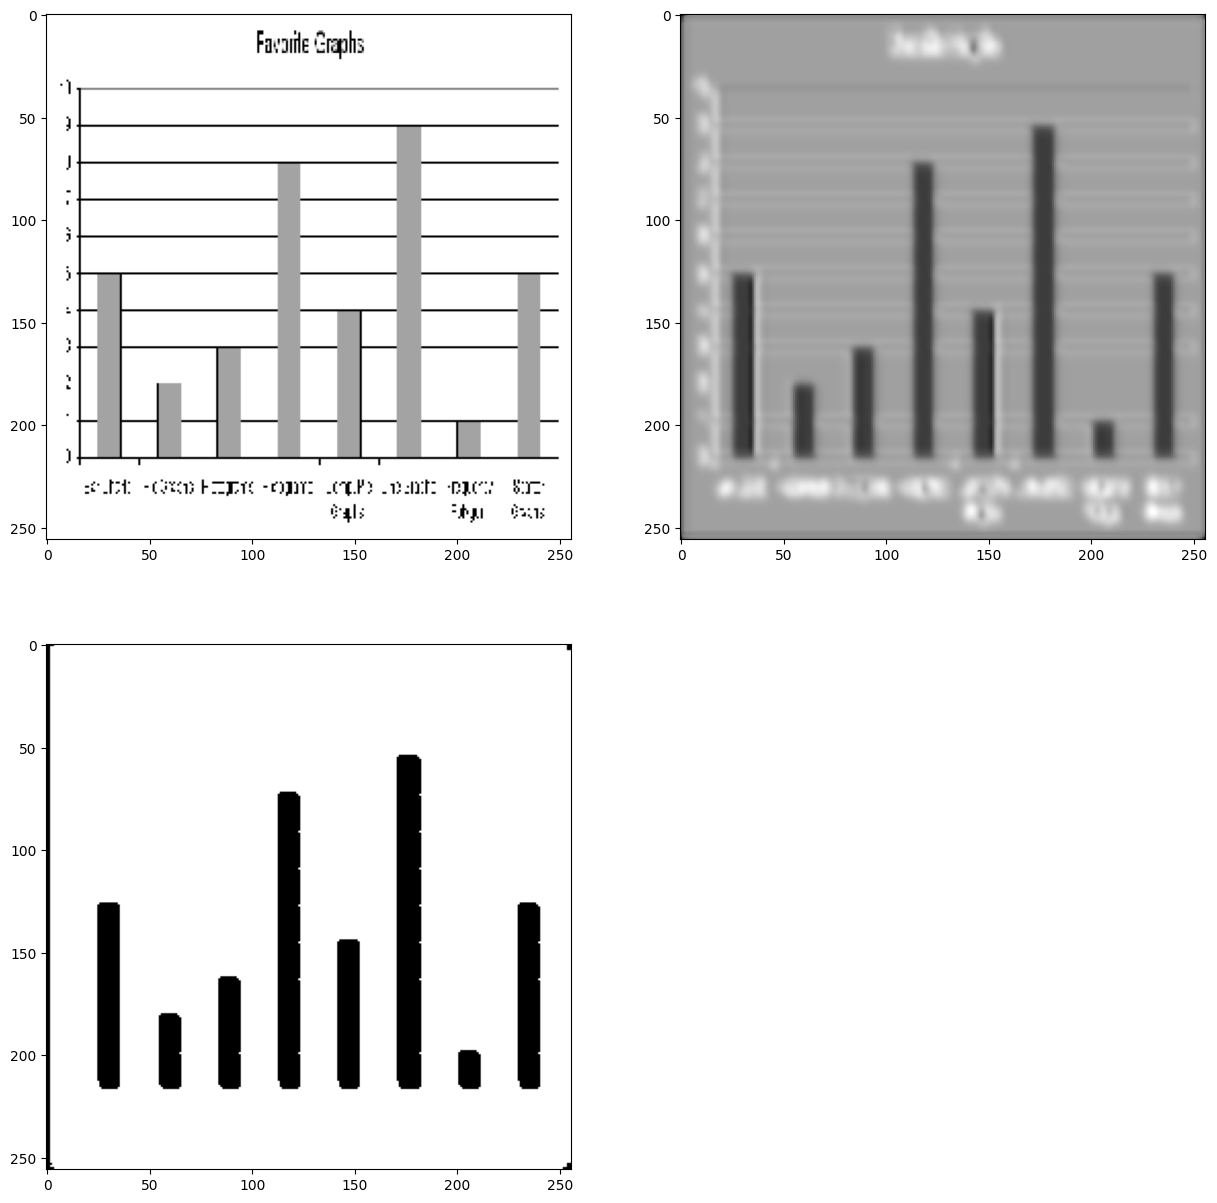

In [16]:
target_path = None
img_path = "Codigos y BD anteriores/Barras/" + f"ejemplos/internet/buenos/1000.jpg"
test_model(model_old_loaded_2021, img_path, (256, 256), target_path)

In [17]:
def segment(img_path, model):
    img = tf.keras.utils.load_img(img_path, target_size=(256,256), color_mode="grayscale")  #, interpolation="bicubic")
    img = tf.keras.utils.img_to_array(img)

    # PREDICCION
    pred = model.predict(img[None,:,:,:]).reshape((256, 256))
    img = img.reshape((256, 256))

    ret, thresh = cv2.threshold(minmax(pred), 0.5, 1, cv2.THRESH_BINARY)
    return thresh.astype(np.uint8)

1/1 [==============================] - 0s 21ms/step


30


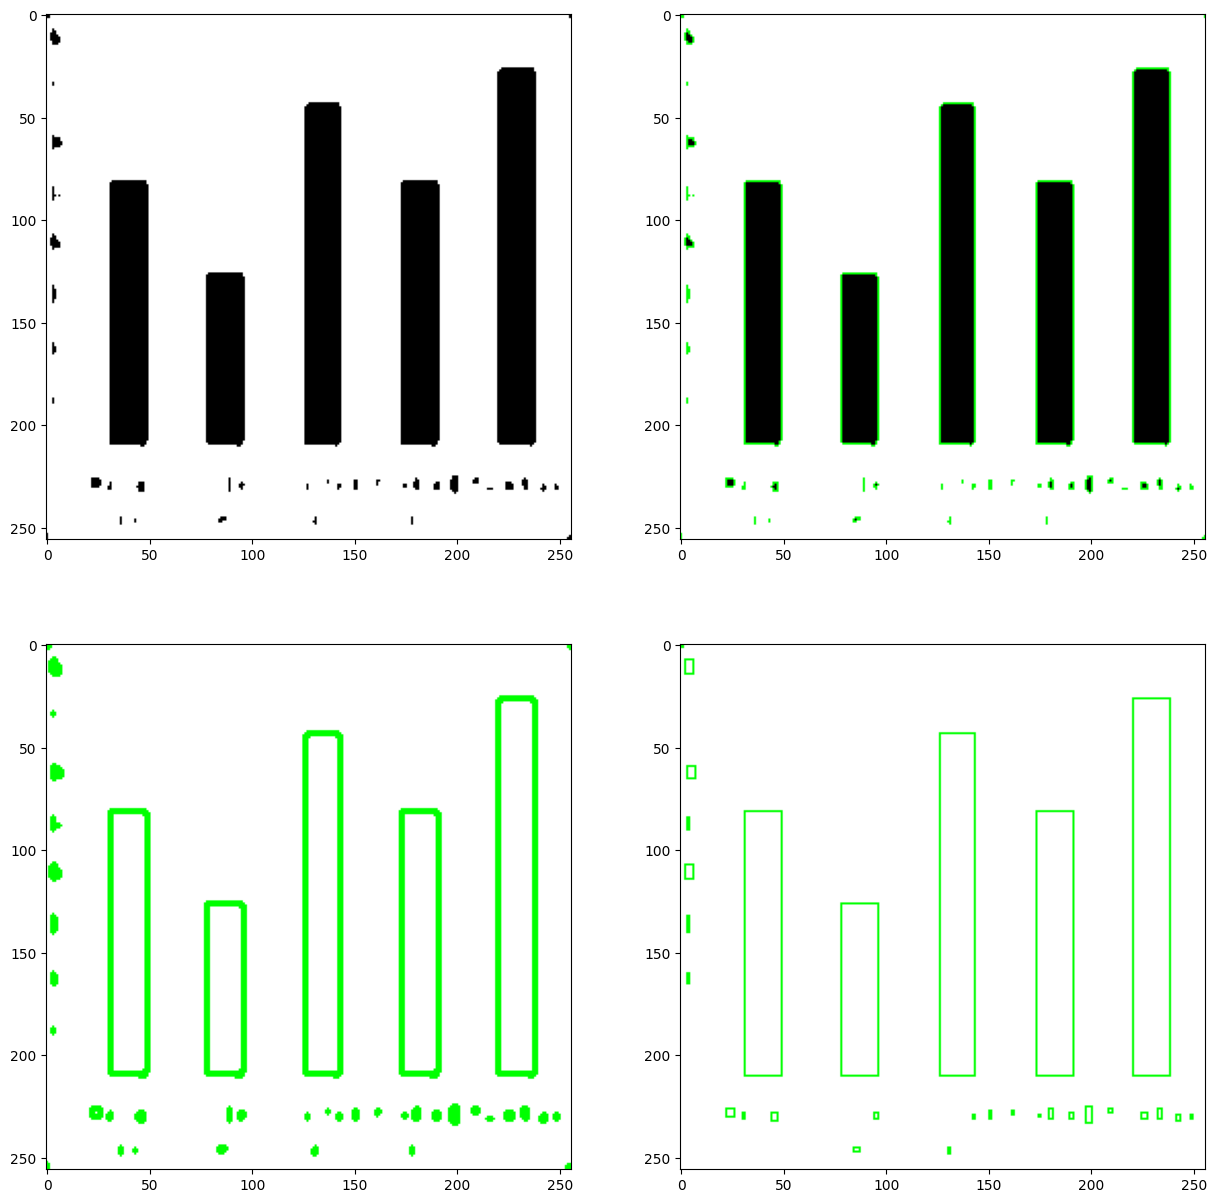

In [18]:
n = 1016
img_path = "Codigos y BD anteriores/Barras/" + f"ejemplos/internet/buenos/{n}.jpg"
target_path = "Codigos y BD anteriores/Barras/" + f"dataset/segmentation-2/test/segmented/{n}.png"

img_path = path_bar_chart_db + "dataset/DB graficos internet/Barras Verticales/Copia de graph_1003.jpg"

# print(segmented.astype(np.uint8).dtype)

segmented = segment(img_path, model_loaded)

# Invert de blanco con negro para encontrar los contours
contours, hierarchy = cv2.findContours(np.where((segmented==0), 1, 0).astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

plt.figure(figsize=(15,15))
plt.subplot(2, 2, 1)
plt.imshow(segmented)

img = cv2.drawContours(cv2.cvtColor(segmented * 255, cv2.COLOR_GRAY2RGB), contours, -1, (0,255,0), 1)

plt.subplot(2, 2, 2)
plt.imshow(img)


plt.subplot(2, 2, 3)
plt.imshow(cv2.drawContours(np.ones((256, 256, 3)) * 255, contours, -1, (0,255,0), 2))

contours = [c for c in contours if c.shape[0] > 3]
print(len(contours))
# print(hierarchy)

img = np.ones((256, 256, 3)) * 255
for bar in contours:
    x_min = bar[:,0,0].min()
    x_max = bar[:,0,0].max()
    y_min = bar[:,0,1].min()
    y_max = bar[:,0,1].max()

    cv2.rectangle(img,(x_min, y_min), (x_max, y_max), (0,255,0), 1)

plt.subplot(2, 2, 4)
plt.imshow(img)


In [19]:
def test_and_save():
    pass

def test_and_save_image(model, img_path, img_name, save_dir, display=True):
    img = tf.keras.utils.load_img(img_path, target_size=(256,256), color_mode="grayscale")  #, interpolation="bicubic")
    img = tf.keras.utils.img_to_array(img)

    # PREDICCION
    pred = model.predict(img[None,:,:,:]).reshape((256, 256))
    img = img.reshape((256, 256))

    # NORMALIZACIÓN
    ret, thresh = cv2.threshold(minmax(pred), 0.5, 1, cv2.THRESH_BINARY)

    # Contornos
    # Invert de blanco con negro para encontrar los contours
    contours, hierarchy = cv2.findContours(np.where((thresh==0), 1, 0).astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contours = [c for c in contours if c.shape[0] > 3]
    # print(len(contours))

    contour_img = np.ones((256, 256, 3)) * 255
    final_img = tf.keras.utils.load_img(img_path, target_size=(256,256))
    final_img = tf.keras.utils.img_to_array(final_img).astype(np.uint8)
    # print(final_img.dtype)
    for bar in contours:
        x_min = bar[:,0,0].min()
        x_max = bar[:,0,0].max()
        y_min = bar[:,0,1].min()
        y_max = bar[:,0,1].max()

    cv2.rectangle(contour_img,(x_min, y_min), (x_max, y_max), (0,255,0), 1)
    cv2.rectangle(final_img,(x_min, y_min), (x_max, y_max), (0,255,0), 2)

    # DISPLAY
    if display:
        plt.figure(figsize=(15, 15))
        plt.gray()
        plt.subplot(2,3,1)
        plt.imshow(img)
        plt.subplot(2,3,2)
        plt.imshow(pred)
        plt.subplot(2,3,3)
        plt.imshow(thresh)
        plt.subplot(2, 3, 4)
        plt.imshow(contour_img)
        plt.subplot(2, 3, 5)
        plt.imshow(final_img)

    # Save
    plt.imsave(save_dir + f"1_grayscale_reshape/{img_name}", img)
    plt.imsave(save_dir + f"2_output_red/{img_name}", pred)
    plt.imsave(save_dir + f"3_threshold/{img_name}", thresh)
    plt.imsave(save_dir + f"4_contornos/{img_name}", contour_img / 255)
    plt.imsave(save_dir + f"5_contornos_sobre_original/{img_name}", final_img)


In [ ]:
# img_path = path_bar_chart_db + f"dataset/segmentation-2/test/segmented/{n}.png"
# test_and_save_image(m, img_path)
imgs_path = path_bar_chart_db + "dataset/segmentation-2/test/color"

for img_name in os.listdir(imgs_path):
  img_path = path_bar_chart_db + f"dataset/segmentation-2/test/color/{img_name}"
  save_dir = path_bar_chart_db + "dataset/segmentation-2/test/output/"
  test_and_save_image(model_loaded, img_path, img_name, save_dir, display=False)


In [ ]:
imgs_path = path_bar_chart_db + "dataset/internet/0_originales/"

for img_name in os.listdir(imgs_path):
    img_path = imgs_path + img_name
    save_dir = path_bar_chart_db + "dataset/internet/"
    test_and_save_image(m, img_path, img_name, save_dir, display=False)